In [1]:
import tensorflow as tf

import pandas as pd
import numpy as np

from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('train.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
test_data = pd.read_csv('test.csv')
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
all_data = data.copy()
all_data = all_data.append(test_data)
print(len(data))
print(len(test_data))
print(len(all_data))
all_data.head()

891
418
1309


D:\program\Anaconda3\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


In [5]:
def hasSame(ticket):
    if len(all_data[all_data['Ticket'] == ticket]) > 1:
        return 1
    else:
        return 0

In [6]:
data['shareTicket'] = data['Ticket'].apply(lambda x: hasSame(x))
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,shareTicket
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


In [7]:
test_data['shareTicket'] = test_data['Ticket'].apply(lambda x: hasSame(x))
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,shareTicket
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1


In [8]:
def getTitle(name):
    if ('Jonkheer.' in name):
        return 0
    elif ('Countess.' in name):
        return 1
    elif ('Sir.' in name):
        return 2
    elif ('Capt.' in name):
        return 3
    elif ('Mrs.' in name):
        return 4
    elif ('Miss.' in name): 
        return 5
    elif ('Mr.' in name):
        return 6
    elif('Master.' in name):
        return 7
    elif ('Rev.' in name):
         return 8
    elif ('Dr.' in name):
        return 9
    elif ('Mlle.' in name):
        return 10
    elif('Col.' in name):
        return 11
    elif('Don.' in name):
        return 12
    elif('Mme.' in name):
        return 13
    elif('Ms.' in name):
        return 14
    elif('Major.' in name):
        return 15
    elif('Lady.' in name):
        return 16
    else:
        return 17

In [9]:
data['Title'] = data['Name'].apply(lambda x: getTitle(x))
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,shareTicket,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,6
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,4
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,5
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,4
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,6


In [10]:
test_data['Title'] = test_data['Name'].apply(lambda x: getTitle(x))
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,shareTicket,Title
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0,6
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0,4
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0,6
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0,6
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1,4


In [11]:
data.pop('Cabin')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,shareTicket,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,0,6
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,1,4
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,0,5
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,1,4
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,0,6


In [12]:
test_data.pop('Cabin')
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,shareTicket,Title
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,0,6
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,0,4
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,0,6
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,0,6
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S,1,4


In [13]:
tmp = data[data['Embarked'].isnull()]
tmp

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,shareTicket,Title
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,NaN,1,5
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,NaN,1,4


In [14]:
data['Embarked']=data['Embarked'].fillna('C')
data[data['Fare'] == 80]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,shareTicket,Title
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,C,1,5
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,C,1,4


In [15]:
# data = data.dropna()
# len(data)

In [16]:
data['family'] = data['SibSp'] + data['Parch']
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,shareTicket,Title,family
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,0,6,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,1,4,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,0,5,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,1,4,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,0,6,0


In [17]:
test_data['family'] = test_data['SibSp'] + test_data['Parch']
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,shareTicket,Title,family
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,0,6,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,0,4,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,0,6,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,0,6,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S,1,4,2


In [18]:
mean = all_data['Age'].median()
mean

28.0

In [19]:
data['Age'].isnull().sum()

177

In [20]:
data['Age'] = data['Age'].fillna(mean)

In [21]:
data['Age'].isnull().sum()

0

In [22]:
test_data['Age'].isnull().sum()

86

In [23]:
test_data['Age'] = test_data['Age'].fillna(mean)

In [24]:
test_data['Age'].isnull().sum()

0

In [25]:
train, test = train_test_split(data, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)

print(len(train))
print(len(val))
print(len(test))

569
143
179


In [26]:
test_data['Survived'] = 0
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,shareTicket,Title,family,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,0,6,0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,0,4,1,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,0,6,0,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,0,6,0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S,1,4,2,0


In [27]:
def df_to_dataset(df, shuffle=False, batch_size=32):
    df = df.copy()
    labels = df.pop('Survived')
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))
    ds = ds.batch(batch_size)
    return ds

In [28]:
evaluate_ds = df_to_dataset(test_data)

In [29]:
train_ds = df_to_dataset(train, shuffle=True)
val_ds = df_to_dataset(val)
test_ds = df_to_dataset(test)

In [30]:
feature_columns = []

for header in ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']:
    feature_columns.append(feature_column.numeric_column(header))
    
age = feature_column.numeric_column('Age')
age_buckets = feature_column.bucketized_column(age, boundaries=[10, 20, 25, 30, 40, 50, 60])
feature_columns.append(age_buckets)

sex = feature_column.categorical_column_with_vocabulary_list('Sex', ['male', 'female'])
sex_one_hot = feature_column.indicator_column(sex)
feature_columns.append(sex_one_hot)

embarked = feature_column.categorical_column_with_vocabulary_list('Embarked', ['S', 'C', 'Q'])
embarked_one_hot = feature_column.indicator_column(embarked)
feature_columns.append(embarked_one_hot)

family = feature_column.categorical_column_with_vocabulary_list(
        'family', data['family'].unique())
feature_columns.append(feature_column.indicator_column(family))

title = feature_column.categorical_column_with_vocabulary_list(
        'Title', data['Title'].unique())
feature_columns.append(feature_column.indicator_column(title))

shareTicket = feature_column.categorical_column_with_vocabulary_list(
        'shareTicket', data['shareTicket'].unique())
feature_columns.append(feature_column.indicator_column(shareTicket))

fare = feature_column.numeric_column('Fare')
fare_buckets = feature_column.bucketized_column(fare, boundaries=[100])
feature_columns.append(fare_buckets)

# ticket = feature_column.categorical_column_with_vocabulary_list(
#         'Ticket', data['Ticket'].unique())
# ticket_embedding = feature_column.embedding_column(ticket, dimension=8)
# feature_columns.append(ticket_embedding)

In [31]:
feature_layer = layers.DenseFeatures(feature_columns)

In [61]:
model = tf.keras.Sequential([
    feature_layer,
    layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.Dropout(0.1),
    layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.Dropout(0.1),
    layers.Dense(1, activation='sigmoid')
])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds, validation_data=val_ds, epochs=110, callbacks=[early_stop])

Epoch 1/110
18/18 [==============================] - 1s 53ms/step - loss: 1.7738 - accuracy: 0.5797 - val_loss: 1.4228 - val_accuracy: 0.3706
Epoch 2/110
18/18 [==============================] - 1s 36ms/step - loss: 1.1870 - accuracy: 0.6106 - val_loss: 1.1498 - val_accuracy: 0.6993
Epoch 3/110
18/18 [==============================] - 1s 35ms/step - loss: 1.0116 - accuracy: 0.6791 - val_loss: 0.9047 - val_accuracy: 0.7483
Epoch 4/110
18/18 [==============================] - 1s 36ms/step - loss: 0.9015 - accuracy: 0.7207 - val_loss: 0.7797 - val_accuracy: 0.7692
Epoch 5/110
18/18 [==============================] - 1s 36ms/step - loss: 0.8297 - accuracy: 0.7411 - val_loss: 0.8892 - val_accuracy: 0.7552
Epoch 6/110
18/18 [==============================] - 1s 36ms/step - loss: 0.8172 - accuracy: 0.7729 - val_loss: 0.8217 - val_accuracy: 0.7552
Epoch 7/110
18/18 [==============================] - 1s 35ms/step - loss: 0.7804 - accuracy: 0.7966 - val_loss: 0.8189 - val_accuracy: 0.7622
Epoch 

18/18 [==============================] - 1s 38ms/step - loss: 0.4813 - accuracy: 0.8332 - val_loss: 0.5146 - val_accuracy: 0.8531
Epoch 59/110
18/18 [==============================] - 1s 37ms/step - loss: 0.4835 - accuracy: 0.8266 - val_loss: 0.5080 - val_accuracy: 0.8671
Epoch 60/110
18/18 [==============================] - 1s 36ms/step - loss: 0.4805 - accuracy: 0.8149 - val_loss: 0.5104 - val_accuracy: 0.8601
Epoch 61/110
18/18 [==============================] - 1s 37ms/step - loss: 0.4770 - accuracy: 0.8212 - val_loss: 0.5097 - val_accuracy: 0.8531
Epoch 62/110
18/18 [==============================] - 1s 37ms/step - loss: 0.4739 - accuracy: 0.8410 - val_loss: 0.5107 - val_accuracy: 0.8741
Epoch 63/110
18/18 [==============================] - 1s 37ms/step - loss: 0.4756 - accuracy: 0.8376 - val_loss: 0.5019 - val_accuracy: 0.8531
Epoch 64/110
18/18 [==============================] - 1s 36ms/step - loss: 0.4726 - accuracy: 0.8247 - val_loss: 0.5077 - val_accuracy: 0.8741
Epoch 65/110

In [62]:
np.max(history.history['val_accuracy'])

0.8811189

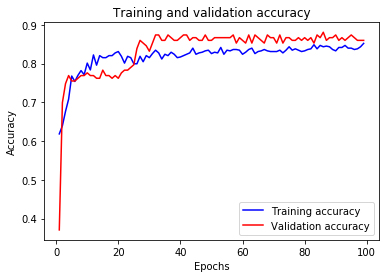

In [63]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, acc, 'b', label='Training accuracy')
# b is for "solid blue line"
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [64]:
predictions = model.predict(evaluate_ds)

In [65]:
df = pd.DataFrame(predictions)

In [66]:
def compare(x):
    if x >= 0.5:
        return 1
    else:
        return 0

In [67]:
labels = df[0].apply(lambda x: compare(x))

In [68]:
result = pd.DataFrame()
result['PassengerId'] = test_data['PassengerId']
result['Survived'] = labels

In [69]:
result[['PassengerId', 'Survived']].to_csv('submission.csv', index=False)